<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span><ul class="toc-item"><li><span><a href="#Presets" data-toc-modified-id="Presets-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Presets</a></span></li><li><span><a href="#Style,-imports,-and-data" data-toc-modified-id="Style,-imports,-and-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Style, imports, and data</a></span></li><li><span><a href="#GPU" data-toc-modified-id="GPU-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>GPU</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Load-data-(freeze-this-and-read-series-of-pickles)" data-toc-modified-id="Load-data-(freeze-this-and-read-series-of-pickles)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load data (freeze this and read series of pickles)</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Modeling</a></span></li></ul></li></ul></div>

# Intro

## Presets

In [1]:
USE_GPU = True
IGNORE_WARN = True
SEED = 42

## Style, imports, and data

In [2]:
import warnings
import matplotlib as mpl
mpl.rcParams['axes.titlesize']='xx-large'
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['axes.labelsize'] = 16
if IGNORE_WARN:
    warnings.filterwarnings('ignore')

In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [5]:
import importlib
import sys

In [6]:
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
# from tensorflow.keras.regularizers import l2, l1

## GPU

In [7]:
if USE_GPU:
    # Enable GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

    # Show GPU
    print("Using GPU")
    print(tf.config.list_physical_devices('GPU'))
else:
    print("Using CPU")

Using GPU
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Model

## Functions

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    "https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/"
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Load data (freeze this and read series of pickles)

In [9]:
df = pd.read_pickle('./data/modeling/model_df.pkl')

In [10]:
n_features = 256625
sym_predict='VLO'
col = f'{sym_predict}_price'
df = pd.concat([df[col], df.drop(col, axis=1)], axis=1)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled.shape

(337, 256625)

In [11]:
reframed = series_to_supervised(df_scaled, 1, 1)
values = reframed.values
train = values[:250]
test = values[250:]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 513249), (250,), (86, 513249), (86,))

In [12]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [31]:
# import pickle

# filepath = './data/modeling/'
# def dump_pickle(var, name):
#     with open(filepath+name, 'wb') as pickle_file:
#         pickle.dump(var, pickle_file)

# dump_pickle(X_train, "X_train.pkl")
# dump_pickle(y_train, "y_train.pkl")
# dump_pickle(X_test, "X_test.pkl")
# dump_pickle(y_test, "y_test.pkl")
# dump_pickle(X_val, "y_test.pkl")
# dump_pickle(y_val, "y_test.pkl")
# dump_pickle(df, "df_modeling_ready.pkl")

## Modeling

In [10]:
# import pickle
# filepath = './data/modeling/'
# def read_pickle(name):
#     with open(filepath+name, 'rb') as pickle_file:
#         return pickle.load(pickle_file)
    
# X_train = read_pickle("X_train.pkl")
# y_train = read_pickle("y_train.pkl")
# X_test = read_pickle("X_test.pkl")
# y_test = read_pickle("y_test.pkl")
# X_val = read_pickle("y_test.pkl")
# y_val = read_pickle("y_test.pkl")
# df = read_pickle("df_modeling_ready.pkl")

In [13]:
#del model
# tf.keras.backend.clear_session()
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[1]
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(.3))
#model.add(Dense(50, activation='relu'))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
earlystopping = EarlyStopping(monitor='val_loss', patience=25)
history = model.fit(X_train, y_train,
                    epochs=2000, batch_size=128,
                    validation_data=(X_test, y_test),
                    verbose=2, shuffle=False,
                    callbacks=[earlystopping])

Epoch 1/2000
2/2 - 1s - loss: 1.1771 - val_loss: 2.2186
Epoch 2/2000
2/2 - 0s - loss: 2.2132 - val_loss: 2.1955
Epoch 3/2000
2/2 - 0s - loss: 2.1893 - val_loss: 2.1699
Epoch 4/2000
2/2 - 0s - loss: 2.1634 - val_loss: 2.1433
Epoch 5/2000
2/2 - 0s - loss: 2.1367 - val_loss: 2.1161
Epoch 6/2000
2/2 - 0s - loss: 2.1094 - val_loss: 2.0886
Epoch 7/2000
2/2 - 0s - loss: 2.0819 - val_loss: 2.0609
Epoch 8/2000
2/2 - 0s - loss: 2.0541 - val_loss: 2.0330
Epoch 9/2000
2/2 - 0s - loss: 2.0262 - val_loss: 2.0051
Epoch 10/2000
2/2 - 0s - loss: 1.9982 - val_loss: 1.9770
Epoch 11/2000
2/2 - 0s - loss: 1.9702 - val_loss: 1.9490
Epoch 12/2000
2/2 - 0s - loss: 1.9421 - val_loss: 1.9209
Epoch 13/2000
2/2 - 0s - loss: 1.9140 - val_loss: 1.8927
Epoch 14/2000
2/2 - 0s - loss: 1.8858 - val_loss: 1.8646
Epoch 15/2000
2/2 - 0s - loss: 1.8577 - val_loss: 1.8364
Epoch 16/2000
2/2 - 0s - loss: 1.8295 - val_loss: 1.8082
Epoch 17/2000
2/2 - 0s - loss: 1.8014 - val_loss: 1.7801
Epoch 18/2000
2/2 - 0s - loss: 1.7732 - 

KeyboardInterrupt: 

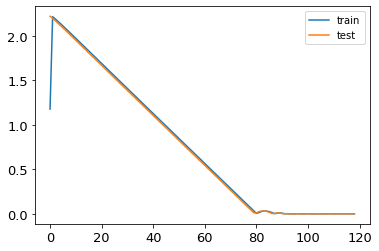

In [15]:
my_loss= history.history['loss']
plt.plot(range(len(my_loss)),my_loss, label='train')
my_val_loss= history.history['val_loss']
plt.plot(range(len(my_loss)),my_val_loss, label='test')
plt.legend()

In [16]:
df.iloc[250:315]

,VLO_price,A_RevenueTTM,A_TotalCash,A_ExDividendDate,A_Dividend,A_DividendYield,A_PriceToBook,A_PriceToSales,A_EnterpriseValue,A_PriceToCashFlow,...,ZYXI_industry_Transportation Infrastructure,ZYXI_industry_Water Utilities,ZYXI_industry_Wireless Telecommunication Services,ZYXI_Exchange_NASDAQ,ZYXI_Exchange_NYSE,ZYXI_Exchange_OTC,ZYXI_Exchange_unknown,ZYXI_DJIA_1,ZYXI_NASDAQ100_1,ZYXI_SP500_1
date,,,,,,,,,,,,,,,,,,,,,
2020-07-30,56.330,5236.000,1324.000,0,0.180,0.742,6.272,5.735,31259800000.000,30.959,...,0,0,0,1,0,0,0,0,0,0
2020-07-31,56.230,5236.000,1324.000,0,0.180,0.751,6.197,5.666,30899440000.000,30.586,...,0,0,0,1,0,0,0,0,0,0
2020-08-03,53.910,5236.000,1324.000,0,0.180,0.747,6.223,5.690,31022640000.000,30.713,...,0,0,0,1,0,0,0,0,0,0
2020-08-04,53.020,5236.000,1324.000,0,0.180,0.727,6.401,5.853,31872720000.000,31.593,...,0,0,0,1,0,0,0,0,0,0
2020-08-05,51.620,5236.000,1324.000,0,0.180,0.738,6.300,5.761,31392240000.000,31.096,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-22,41.280,5223.000,1358.000,0,0.180,0.687,6.503,6.202,33542470000.000,32.394,...,0,0,0,1,0,0,0,0,0,0
2020-10-23,41.970,5223.000,1358.000,0,0.180,0.674,6.624,6.317,34141930000.000,32.994,...,0,0,0,1,0,0,0,0,0,0
2020-10-26,39.540,5223.000,1358.000,0,0.180,0.678,6.586,6.282,33956530000.000,32.808,...,0,0,0,1,0,0,0,0,0,0


In [20]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (86,513249) (256625,) (86,513249) 

In [19]:
pd.DataFrame(scaler.inverse_transform(model.predict(X_test)), columns=df.columns)[col]

ValueError: non-broadcastable output operand with shape (86,1) doesn't match the broadcast shape (86,256625)

In [19]:
df.iloc[250:315][col]

date
2020-07-30   56.330
2020-07-31   56.230
2020-08-03   53.910
2020-08-04   53.020
2020-08-05   51.620
              ...  
2020-10-22   41.280
2020-10-23   41.970
2020-10-26   39.540
2020-10-27   38.260
2020-10-28   36.190
Name: VLO_price, Length: 65, dtype: float64